# Figures for paper

In [1]:
# this import all the necessary python packages
import pandas as pd  # read in dataframe
import numpy as np  # numerical computing in Python
import matplotlib.pyplot as plt  # plotting
from matplotlib.collections import PolyCollection
import matplotlib.dates as mdates
from tqdm.notebook import tqdm_notebook as tqdm  # progress bar
from joblib import Parallel, delayed  # parallel reading of templates
from upsetplot import UpSet  # graph with interactions
import requests  # internet request to download template
import time
from datetime import datetime
import tempfile  # temporary file and folder
import os
import warnings
warnings.filterwarnings('ignore')
import json  # save errors detected as .json file
import uuid  # generate random string in case id are the same
from openpyxl import load_workbook # enable saving into existing workbook while keeping format
from openpyxl.cell.cell import ILLEGAL_CHARACTERS_RE  # to remove some \x021 characters
from openpyxl.utils.dataframe import dataframe_to_rows
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker  # create an interactive map
from ipywidgets import HTML  # for rich output display
import unicodedata  # to escape non ascii string for experiment ID
from copy import deepcopy  # to keep copy of checked template for debugging
import zipfile  # to unzip climate data
import rasterio  # for getting climate data
import fiona  # load shapefile for bioclimatic regions
from shapely.geometry import shape, Point  # to test wether point lies in shape

# in case of missing packages, just the below line in a new cell with the missing package name
#!pip install <package_name>

In [2]:
# read xlsx or google sheet url, make sure ID's are string and remove 'Unamed' columns
def readExcel(fname):
    if fname[:4] == 'http': # it's a google sheet url
        fname = '/'.join(fname.split('/')[:-1] + ['export?format=xlsx'])
    dfdic = pd.read_excel(fname, sheet_name=None, skiprows=[0, 1, 3])

    # remove Unnamed columns
    for key in dfdic.keys():
        ie = dfdic[key].columns.str.contains('Unnamed')
        dfdic[key] = dfdic[key].drop(dfdic[key].columns[ie], axis=1)
        dfdic[key] = dfdic[key].dropna(axis=0, how='all').replace(' ', pd.NA).reset_index(drop=True)
        if key == 'dropDownList':
            dfdic[key] = dfdic[key].rename(columns={'Measurement method': 'Analysis method'})

    # make all ID as string
    for key in dfdic:
        for dtype in ['Experiment ID', 'Treatment ID']:
            if dtype in dfdic[key].columns:
                dfdic[key][dtype] = dfdic[key][dtype].astype(str)

    return dfdic

#dfdic = readExcel('../data/ejp7_3-lte-db.xlsx')

In [3]:
dfdic = readExcel('../output/carboseq-wp2-db.xlsx')

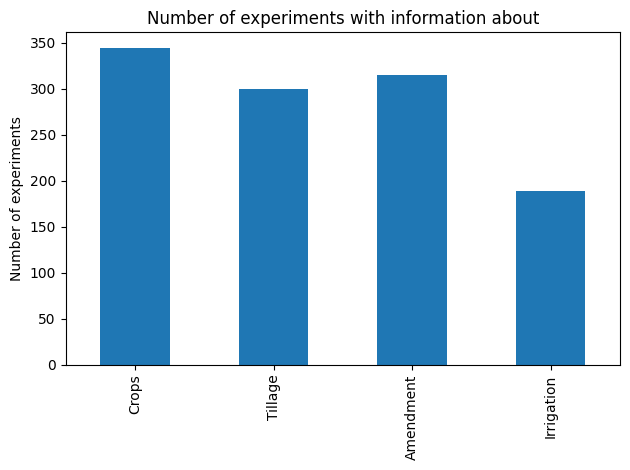

In [4]:
# data availability for each tab
sheets = [ 'crops', 'tillage', 'amendment', 'irrigation']
idcols = ['Experiment ID', 'Treatment ID', 'Crop ID', 'Publication ID']
dfavai = pd.DataFrame()
dfavai['Experiment ID'] = dfdic['experiment']['Experiment ID']
for sheet in sheets:
  df = dfdic[sheet]
  cols = df.columns[df.columns.isin(idcols)]
  index = df.drop(cols, axis=1).dropna(axis=0, how='all').index
  expids = df.loc[index, 'Experiment ID']
  dfavai[sheet] = dfavai['Experiment ID'].isin(expids.tolist())

dfavai = dfavai.rename(columns={
    'treatment': 'Crop rotation',
    'crops': 'Crops',
    'tillage': 'Tillage',
    'amendment': 'Amendment',
    'irrigation': 'Irrigation'
})

fig, ax = plt.subplots()
ax.set_title('Number of experiments with information about')
#ax.axhline(dfavai.shape[0], color='k', linestyle='--')
dfavai[dfavai.columns[1:]].sum().plot(kind='bar', ax=ax,
                                      ylabel='Number of experiments');
fig.tight_layout()
fig.savefig('../figures/nb-experiments.pdf')

In [5]:
dfavai[dfavai['Crops'].eq(False)]

,Experiment ID,Crops,Tillage,Amendment,Irrigation
7,Slepe05V127.1,False,True,False,False
8,KJELL05V.1,False,True,True,False
47,MO,False,False,False,False
48,MA,False,False,False,False
49,SA,False,False,False,False
...,...,...,...,...,...
427,Orup,False,False,False,False
428,Orja,False,False,False,False
429,Ekebo,False,False,False,False
430,Tanikon tillage trial,False,False,False,False


In [6]:
df = dfdic['crops']
df[df['Experiment ID'].eq('Edinburgh South Road')]

,Experiment ID,Treatment ID,Rotation,Crop ID,Crop type,Cropping system,Crop,Harvesting/Termination method,Harvesting frequency,Sowing period,Harvesting/Termination period,Residues removal,Residues incorporation,Residues burning,Residues (comment),Crop (comment)
7740,Edinburgh South Road,CT,NaN,___,Main crop,Monoculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7741,Edinburgh South Road,MT,NaN,___,Main crop,Monoculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7742,Edinburgh South Road,NT-LT,NaN,___,Main crop,Monoculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7743,Edinburgh South Road,NT-ST,NaN,___,Main crop,Monoculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = dfdic['experiment']
df[df['Experiment ID'].eq('KJELL05V.1')]['templateID']

8    n0009
Name: templateID, dtype: object

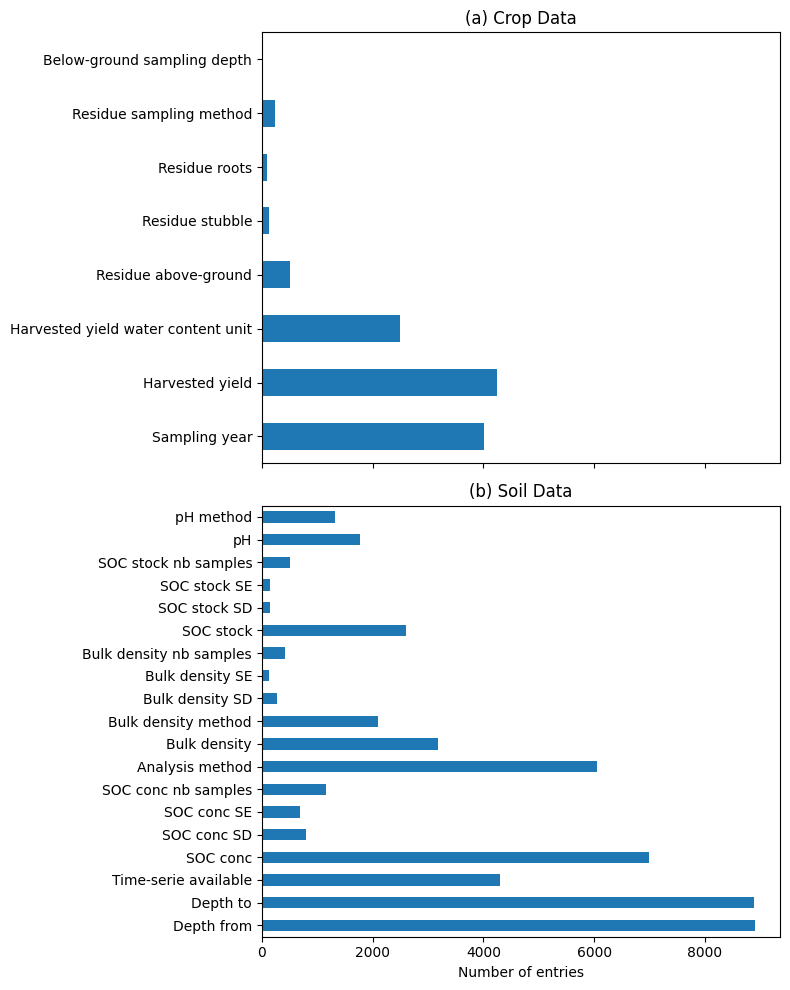

In [8]:
# data status
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
df = dfdic['data-crop'].copy()
df = df.drop(['Harvested yield water content amount'], axis=1)
df = df.rename(columns={
    'Harvested yield water content': 'Harvested yield water content unit'
})
df[df.columns[4:-1]].notnull().sum().plot(kind='barh', ylabel='', title='(a) Crop Data', ax=axs[0])
df = dfdic['data-soil'].copy()
df[df.columns[4:-1]].notnull().sum().plot(kind='barh', xlabel='Number of entries', title='(b) Soil Data', ax=axs[1])
fig.tight_layout()
fig.savefig('../figures/data-status.pdf')
fig.savefig('../figures/data-status.eps')
fig.savefig('../figures/data-status.jpg', dpi=300)

In [9]:
#dfdic = readExcel('../output/carboseq-wp2-db-levels.xlsx')

In [10]:
# identify which management practice is treatment specific
def extractTreatment(dfdic):
    t0 = time.time()
    sheets = ['treatment', 'crops', 'tillage', 'amendment', 'irrigation', 'pest-weed', 'grazing']
    sheets = [sheet for sheet in sheets if sheet in dfdic.keys()]
    expids = dfdic['experiment']['Experiment ID'].unique()
    x = np.zeros((len(expids), len(sheets)), dtype=bool)
    dft = pd.DataFrame(x, columns=sheets) # True if the practice is part of treatment
    dft.insert(0, 'Experiment ID', expids)
    # dfd to store which columns are making it a treatment
    dfd = dict(zip(dfdic.keys(), []*len(dfdic.keys())))
    ddic = dict(zip(sheets, [0]*len(sheets)))
    for sheet in tqdm(sheets):
        dfdsheet = []  # list of pandas.Series
        df = dfdic[sheet]
        # prepare columns to exclude as probably different between treatment
        # without signication that this is a factor investigated
        cols = df.columns[~df.columns.isin(['Experiment ID', 'Treatment ID', 'Crop ID',
                                            'Publication ID', 'Treatment definition',
                                            'Year started', 'Year ended', 'Reference treatment'])]
        cols = cols[~cols.str.contains('(comment)')]
        vals = df[cols].values  # extract all values as numpy array

        sameRows = True  # flag to know about different number of rows between treatid
        for i, expid in enumerate(tqdm(expids)):
            iexp = df['Experiment ID'] == expid

            # define dfd (number > 0 if columns is different between treatid)
            dfdexp = []

            isTreatment = False
            if (iexp.sum() > 0): # sheet might be empty for expid
                treatids = df[iexp]['Treatment ID'].unique()
                
                # create mask for NaN values and index for each treatid
                ies = np.zeros((df.shape[0], len(treatids)), dtype=bool)
                xs = []
                masks = []
                for j, treatid in enumerate(treatids):
                    ies[:, j] = df['Treatment ID'].eq(treatid) & iexp
                    x = vals[ies[:, j]]
                    xs.append(x)
                    masks.append(x != x)  # NaN is always different from itself

                # compare all combinations of treatids (lower triangle matrix)
                for j, treatid1 in enumerate(treatids[:-1]):
                    for jj, treatid2 in enumerate(treatids[j+1:]):
                        k = j + 1 + jj

                        # test if same number of rows between the two treatments
                        if ies[:, j].sum() == ies[:, k].sum():

                            # let's check if all the rows are identical between the two treatments
                            imatch = xs[j] == xs[k]
                            inan = masks[j] & masks[k]
                            imatch[inan] = True  # NaN == NaN set to True
                            
                            # if not all values are equal, it's a treatment
                            if imatch.all() == False:
                                isTreatment = True
                                # try to identify which columns make it a treatment
                                # we don't want the column to be chosen because of NaN vs other value
                                inancols = inan.any(0)

                                # we don't want identical columns
                                ieqcols = imatch.all(0)

                                # columns that are different between the 
                                # two treatments ID, excluding all columns
                                # that contains at least one NaN
                                idiff = ~ieqcols & ~inancols
                                dfdexp += cols[idiff].tolist()
                                #dfd[sheet].loc[i, cols[idiff]] += 1
                        else:
                            # they don't have the same number of rows
                            isTreatment = True
            
                            # try to identify which rows makes it a treatment
                            if sameRows:
                                ddic[sheet] += 1
                                sameRows = False

            # create dict for dfd
            s = dict(zip(dfdexp, [1]*len(dfdexp)))
            s['Experiment ID'] = expid
            dfdsheet.append(s)

            if isTreatment is True:
                dft.loc[dft['Experiment ID'] == expid, sheet] = True
        
        # create dataframe for dfd
        dfd[sheet] = pd.DataFrame(dfdsheet).fillna(0)
    print('automatic treatment extraction... done ({:.2f}s)'.format(time.time() - t0))

    return dft, dfd, ddic

# dfdic2 = readExcel(datadir + 'templates/template-n0002.xlsx')
# dft, dfd, ddic = extractTreatment(dfdic)
# display(dft)

In [11]:
# identify factors and perhaps merge this with existing dfe for tasks
dft, dfd, ddic = extractTreatment(dfdic)
dft.head()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

automatic treatment extraction... done (10.64s)


,Experiment ID,treatment,crops,tillage,amendment,irrigation
0,Fuchsenbigl_90,False,False,True,False,False
1,KIRCH13V63.2a,False,True,False,True,False
2,KIRCH13V63.2b,False,True,False,True,False
3,Ritzlhof,False,False,False,True,False
4,Askov-LTE,False,False,False,True,False


88  experiments with different treatments investigating "treatment"
	Different number of rows between treatments: 0
	Land use: 56
	Crop rotation: 51
203 experiments with different treatments investigating "crops"
	Different number of rows between treatments: 1
	Residues removal: 94
	Crop: 85
	Residues incorporation: 78
	Cropping system: 61
	Crop type: 48
	Harvesting/Termination method: 39
	Rotation: 36
	Residues burning: 36
	Harvesting frequency: 32
	Harvesting/Termination period: 30
	Sowing period: 23
190 experiments with different treatments investigating "tillage"
	Different number of rows between treatments: 1
	Tillage system: 160
	Tillage method: 138
	Tillage depth: 137
	Permanent soil area covered by residues or crops: 49
	Tillage period: 43
	Rotation: 38
169 experiments with different treatments investigating "amendment"
	Different number of rows between treatments: 1
	Type of fertilizer/amendment: 135
	Fertilizer/Amendment application rate: 80
	Fertilizer/Amendment application 

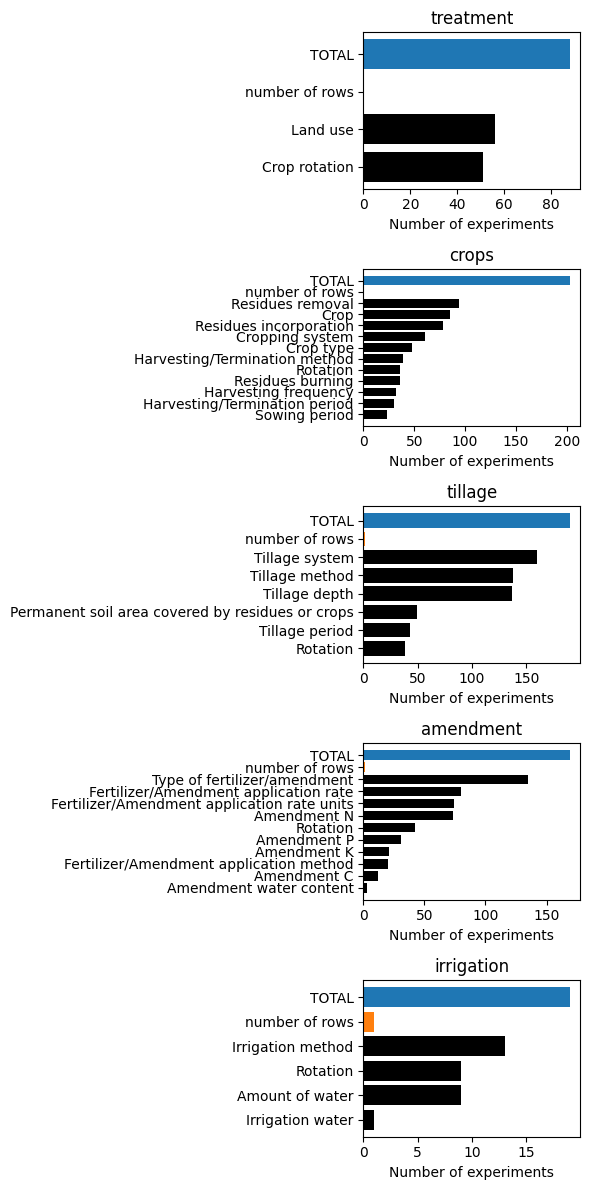

In [12]:
# why are they treatment? (from an automatic perspective)
fig, axs = plt.subplots(5, 1, figsize=(6, 12))
axs = axs.flatten()
for i, key in enumerate(['treatment', 'crops', 'tillage', 'amendment', 'irrigation']):
    print('{:<3d} experiments with different treatments investigating "{:s}"'.format(dft[key].sum(), key))
    df = dfd[key]
    dcols = df.columns[~df.columns.isin(['Experiment ID', 'Treatment ID'])]
    dcols = dcols[~dcols.str.contains('comment')]
    s = df[dcols].sum().astype(int).sort_values(ascending=False)
    s = s[s != 0]
    ax = axs[i]
    ax.set_title(key)
    ax.barh(0, dft[key].sum())
    ax.barh(1, ddic[key])
    print('\tDifferent number of rows between treatments: {:d}'.format(ddic[key]))
    for i in range(s.shape[0]):
        print('\t' + s.index[i] + ': ' + str(s[i]))
        ax.barh(i+2, s[i], color='k')
    ax.set_yticks(np.arange(s.shape[0] + 2))
    ax.invert_yaxis()
    ax.set_yticklabels(['TOTAL', 'number of rows'] + s.index.tolist())
    ax.set_xlabel('Number of experiments')
#axs[-1].remove()
fig.tight_layout()

In [13]:
dft[dft[dft.columns[1:]].eq(False).all(axis=1)]

,Experiment ID,treatment,crops,tillage,amendment,irrigation
10,Cork_oak_dehesha,False,False,False,False,False
14,AF_BE_01,False,False,False,False,False
17,AF_BE_02_StPietersLeeuw1,False,False,False,False,False
18,AF_BE_02_StPietersLeeuw2,False,False,False,False,False
19,AF_BE_02_Haut-Ittre1,False,False,False,False,False
...,...,...,...,...,...,...
426,Ugglarp,False,False,False,False,False
427,Orup,False,False,False,False,False
428,Orja,False,False,False,False,False
429,Ekebo,False,False,False,False,False


In [14]:
#dft = dft.drop(['treatment'], axis=1)
dic = dict(zip(
    dft.columns,
    [col.capitalize() for col in dft.columns]))
dic['treatment'] = 'Crop rotation/Land use'
dft = dft.rename(columns=dic)

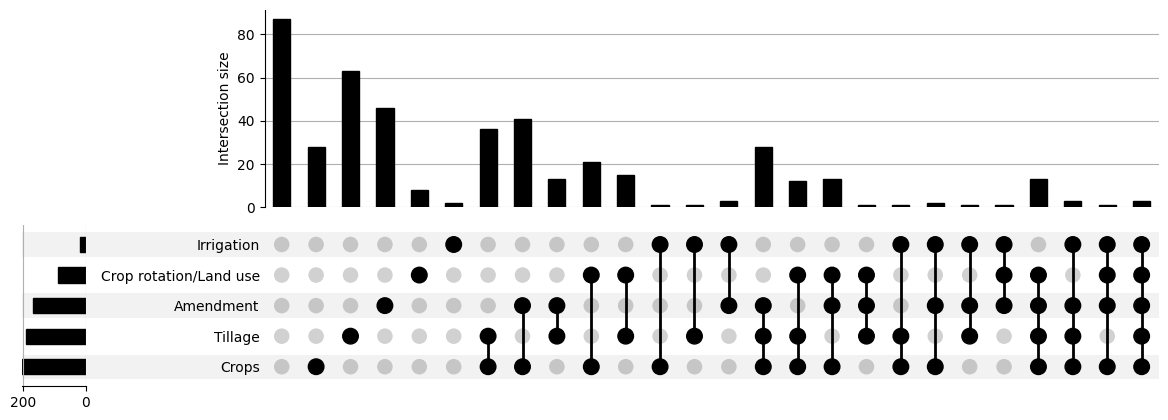

In [15]:
# plot interactions between treatments investigated
dfcount = dft.set_index(dft.columns[1:].tolist())
dfcount
fig = plt.figure()
_ = UpSet(dfcount).plot(fig=fig)
fig.savefig('../figures/upset.pdf')